In [20]:
import numpy as np
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import scipy.stats as stats
import json
import pickle
from tqdm.notebook import tqdm

from pcgsepy.xml_conversion import convert_xml_to_structure

In [21]:
RUN_ANALYSIS = False

In [22]:
fuots = []
fiots = []
volumes = []
lom = []
los = []

In [23]:
SPACESHIPS_DIR = '../steam-workshop-downloader/content'

available_spaceships = os.listdir(SPACESHIPS_DIR)[1:]


def parse_stats():
    for s in tqdm(available_spaceships, desc='Analyzing spaceships...'):
        bp = os.path.join(SPACESHIPS_DIR, s)
        try:
            root = ET.parse(bp).getroot()
            structure = convert_xml_to_structure(root_node=root)
            structure.sanify()

            functional_blocks_volume, filled_volume = 0., 0.
            for b in structure.get_all_blocks():
                if not b.block_type.startswith('MyObjectBuilder_CubeBlock_'):
                    functional_blocks_volume += b.volume
                filled_volume += b.volume

            total_volume = structure.as_array().shape
            total_volume = total_volume[0] * total_volume[1] * total_volume[2]

            fuots.append(functional_blocks_volume / (functional_blocks_volume + filled_volume))
            fiots.append((functional_blocks_volume + filled_volume) / total_volume)
            volumes.append(functional_blocks_volume + filled_volume)

            total_volume = structure.as_array().shape
            largest_axis, medium_axis, smallest_axis = reversed(sorted(list(total_volume)))
            lom.append(largest_axis / medium_axis)
            los.append(largest_axis / smallest_axis)
        except Exception:
            pass

In [24]:
if not os.path.exists('spaceships_stats.json') or RUN_ANALYSIS:
    parse_stats()
    with open('spaceships_stats.json', 'w') as f:
        json.dump({
            'volumes': volumes,
            'fuots': fuots,
            'fiots': fiots,
            'lom': lom,
            'los': los
        }, f)
else:
    with open('spaceships_stats.json', 'r') as f:
        spaceships_stats = json.load(f)
        fuots = spaceships_stats['fuots']
        fiots = spaceships_stats['fiots']
        volumes = spaceships_stats['volumes']
        lom = spaceships_stats['lom']
        los = spaceships_stats['los']

In [25]:
N_BINS = int(np.ceil(len(volumes) / 3))
VOLUME_CUTOFF = 1e6
COLOR_BINS = '#4CD7D0'
COLOR_LINE = '#4C5270'

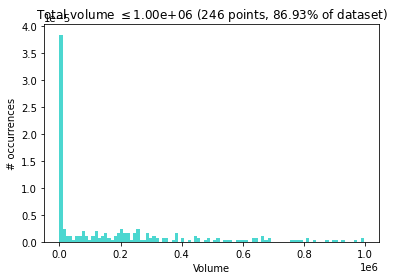

In [26]:
to_plot = [v for v in volumes if v <= VOLUME_CUTOFF]
diff = 100 * len(to_plot) / len(volumes)
plt.hist(to_plot, bins=N_BINS, fc=COLOR_BINS, density=True)
plt.title(f'Total volume $\\leq${VOLUME_CUTOFF:.2e} ({len(to_plot)} points, {np.round(diff, 2)}% of dataset)')
plt.ylabel('# occurrences')
plt.xlabel('Volume')
plt.savefig('stats-volume.png', transparent=True)
plt.show()

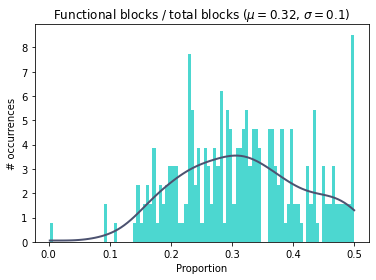

In [27]:
from sklearn.neighbors import KernelDensity

to_analyze = [f for f, v in zip(fuots, volumes) if v <= VOLUME_CUTOFF]
mean, std = np.mean(to_analyze), np.std(to_analyze)
x = np.linspace(min(to_analyze), max(to_analyze), N_BINS)
gkde = stats.gaussian_kde(to_analyze)
estimated = gkde.evaluate(x)

with open('futo.pkl', 'wb') as f:
    pickle.dump(gkde, f)

plt.hist(to_analyze, bins=N_BINS, fc=COLOR_BINS, density=True)
plt.plot(x, estimated, c=COLOR_LINE, lw=2)
plt.title(f'Functional blocks / total blocks ($\\mu=${np.round(mean, 2)}, $\\sigma=${np.round(std, 2)})')
plt.ylabel('# occurrences')
plt.xlabel('Proportion')
plt.savefig('stats-futo.png', transparent=True)
plt.show()

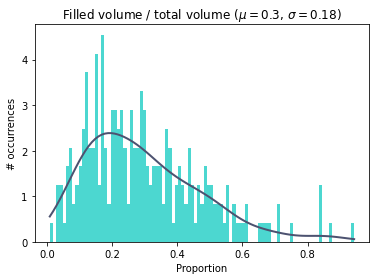

In [28]:
to_analyze = [f for f, v in zip(fiots, volumes) if v <= VOLUME_CUTOFF]
mean, std = np.mean(to_analyze), np.std(to_analyze)
x = np.linspace(min(to_analyze), max(to_analyze), N_BINS)
gkde = stats.gaussian_kde(to_analyze)
estimated = gkde.evaluate(x)

with open('tovo.pkl', 'wb') as f:
    pickle.dump(gkde, f)

plt.hist(to_analyze, bins=N_BINS, fc=COLOR_BINS, density=True)
plt.plot(x, estimated, c=COLOR_LINE, lw=2)
plt.title(f'Filled volume / total volume ($\\mu=${np.round(mean, 2)}, $\\sigma=${np.round(std, 2)})')
plt.ylabel('# occurrences')
plt.xlabel('Proportion')
plt.savefig('stats-tovo.png', transparent=True)
plt.show()

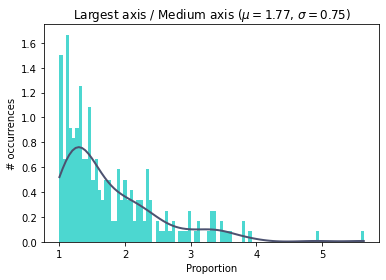

In [29]:
to_analyze = [f for f, v in zip(lom, volumes) if v <= VOLUME_CUTOFF]
mean, std = np.mean(to_analyze), np.std(to_analyze)
x = np.linspace(min(to_analyze), max(to_analyze), N_BINS)
gkde = stats.gaussian_kde(to_analyze)
estimated = gkde.evaluate(x)

with open('mame.pkl', 'wb') as f:
    pickle.dump(gkde, f)

plt.hist(to_analyze, bins=N_BINS, fc=COLOR_BINS, density=True)
plt.plot(x, estimated, c=COLOR_LINE, lw=2)
plt.title(f'Largest axis / Medium axis ($\\mu=${np.round(mean, 2)}, $\\sigma=${np.round(std, 2)})')
plt.ylabel('# occurrences')
plt.xlabel('Proportion')
plt.savefig('stats-mame.png', transparent=True)
plt.show()

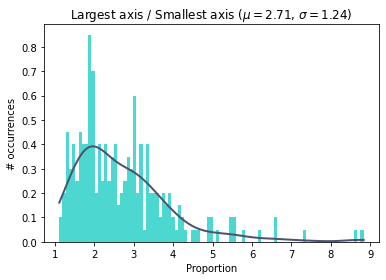

In [30]:
to_analyze = [f for f, v in zip(los, volumes) if v <= VOLUME_CUTOFF]
mean, std = np.mean(to_analyze), np.std(to_analyze)
x = np.linspace(min(to_analyze), max(to_analyze), N_BINS)
gkde = stats.gaussian_kde(to_analyze)
estimated = gkde.evaluate(x)

with open('mami.pkl', 'wb') as f:
    pickle.dump(gkde, f)

plt.hist(to_analyze, bins=N_BINS, fc=COLOR_BINS, density=True)
plt.plot(x, estimated, c=COLOR_LINE, lw=2)
plt.title(f'Largest axis / Smallest axis ($\\mu=${np.round(mean, 2)}, $\\sigma=${np.round(std, 2)})')
plt.ylabel('# occurrences')
plt.xlabel('Proportion')
plt.savefig('stats-mami.png', transparent=True)
plt.show()